In [1]:
import torch, os
torch.manual_seed(0) 
import warnings;warnings.filterwarnings("ignore")
from HINT.dataloader import csv_three_feature_2_dataloader, generate_admet_dataloader_lst
from HINT.molecule_encode import MPNN, ADMET 
from HINT.icdcode_encode import GRAM, build_icdcode2ancestor_dict
from HINT.protocol.model import ProtocolEmbedding
from HINT.model import HINTModel
device = torch.device("cuda:0")
if not os.path.exists("figure"):
	os.makedirs("figure")

In [2]:
base_name = 'phase_III' ### 'toy', 'phase_I', 'phase_II', 'phase_III', 'indication'
datafolder = "data"
train_file = os.path.join(datafolder, base_name + '_train.csv')
valid_file = os.path.join(datafolder, base_name + '_valid.csv')
test_file = os.path.join(datafolder, base_name + '_test.csv')

In [3]:
mpnn_model = MPNN(mpnn_hidden_size = 50, mpnn_depth=3, device = device)
admet_model_path = "save_model/admet_model.ckpt"
if not os.path.exists(admet_model_path):
	admet_dataloader_lst = generate_admet_dataloader_lst(batch_size=32)
	admet_trainloader_lst = [i[0] for i in admet_dataloader_lst]
	admet_testloader_lst = [i[1] for i in admet_dataloader_lst]
	admet_model = ADMET(molecule_encoder = mpnn_model, 
						highway_num=2, 
						device = device, 
						epoch=3, 
						lr=5e-4, 
						weight_decay=0, 
						save_name = 'admet_')
	admet_model.train(admet_trainloader_lst, admet_testloader_lst)
	torch.save(admet_model, admet_model_path)
else:
	admet_model = torch.load(admet_model_path)
	admet_model = admet_model.to(device)
	admet_model.set_device(device)

In [4]:
train_loader = csv_three_feature_2_dataloader(train_file, shuffle=True, batch_size=32) 
valid_loader = csv_three_feature_2_dataloader(valid_file, shuffle=False, batch_size=32) 
test_loader = csv_three_feature_2_dataloader(test_file, shuffle=False, batch_size=32) 

In [5]:
icdcode2ancestor_dict = build_icdcode2ancestor_dict()
gram_model = GRAM(embedding_dim = 50, icdcode2ancestor = icdcode2ancestor_dict, device = device)
protocol_model = ProtocolEmbedding(output_dim = 50, highway_num=3, device = device)

PR-AUC   mean: 0.8034 std: 0.0126
F1       mean: 0.8126 std: 0.0120
ROC-AUC  mean: 0.6872 std: 0.0207
NCT01786824 0 0.721
NCT01887717 0 0.541
NCT01926236 1 0.372
NCT01936844 1 0.423
NCT01964391 1 0.387
NCT01968213 1 0.435
NCT01980875 0 0.818
NCT01980888 0 0.818
NCT01986101 0 0.678
NCT01987895 1 0.441
NCT01989676 1 0.388
NCT01994720 0 0.716
NCT02000622 1 0.412
NCT02008227 1 0.337
NCT02008318 0 0.803
NCT02008916 1 0.373
NCT02012959 0 0.761
NCT02019420 1 0.494
NCT02020278 0 0.759
NCT02025725 0 0.512
NCT02031081 0 0.831
NCT02038036 1 0.377
NCT02038179 0 0.836
NCT02038920 1 0.384
NCT02044354 1 0.458
NCT02044510 0 0.684
NCT02045290 0 0.649
NCT02045862 1 0.393
NCT02048813 1 0.387
NCT02051608 1 0.368
NCT02058108 0 0.707
NCT02066129 0 0.860
NCT02066181 1 0.332
NCT02070757 1 0.369
NCT02072434 1 0.355
NCT02072824 1 0.425
NCT02075840 1 0.343
NCT02079246 1 0.369
NCT02081690 0 0.896
NCT02087059 1 0.483
NCT02104674 0 0.863
NCT02105961 0 0.888
NCT02107196 0 0.722
NCT02107703 1 0.391
NCT02110303 0 0.67

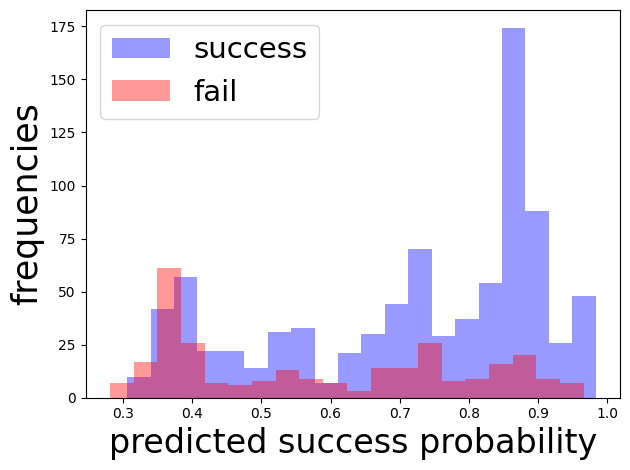

In [6]:
hint_model_path = "save_model/" + base_name + ".ckpt"
if not os.path.exists(hint_model_path):
	model = HINTModel(molecule_encoder = mpnn_model, 
			 disease_encoder = gram_model, 
			 protocol_encoder = protocol_model,
			 device = device, 
			 global_embed_size = 50, 
			 highway_num_layer = 2,
			 prefix_name = base_name, 
			 gnn_hidden_size = 50,  
			 epoch = 3,
			 lr = 1e-3, 
			 weight_decay = 0, 
			)
	model.init_pretrain(admet_model)
	model.learn(train_loader, valid_loader, test_loader)
	model.bootstrap_test(test_loader)
	torch.save(model, hint_model_path)
else:
	model = torch.load(hint_model_path)
	model.bootstrap_test(test_loader)

PR-AUC   mean: 0.8095 std: 0.0117
F1       mean: 0.8134 std: 0.0089
ROC-AUC  mean: 0.6777 std: 0.0181
NCT01786824 0 0.721
NCT01887717 0 0.541
NCT01926236 1 0.372
NCT01936844 1 0.423
NCT01964391 1 0.387
NCT01968213 1 0.435
NCT01980875 0 0.818
NCT01980888 0 0.818
NCT01986101 0 0.678
NCT01987895 1 0.441
NCT01989676 1 0.388
NCT01994720 0 0.716
NCT02000622 1 0.412
NCT02008227 1 0.337
NCT02008318 0 0.803
NCT02008916 1 0.373
NCT02012959 0 0.761
NCT02019420 1 0.494
NCT02020278 0 0.759
NCT02025725 0 0.512
NCT02031081 0 0.831
NCT02038036 1 0.377
NCT02038179 0 0.836
NCT02038920 1 0.384
NCT02044354 1 0.458
NCT02044510 0 0.684
NCT02045290 0 0.649
NCT02045862 1 0.393
NCT02048813 1 0.387
NCT02051608 1 0.368
NCT02058108 0 0.707
NCT02066129 0 0.860
NCT02066181 1 0.332
NCT02070757 1 0.369
NCT02072434 1 0.355
NCT02072824 1 0.425
NCT02075840 1 0.343
NCT02079246 1 0.369
NCT02081690 0 0.896
NCT02087059 1 0.483
NCT02104674 0 0.863
NCT02105961 0 0.888
NCT02107196 0 0.722
NCT02107703 1 0.391
NCT02110303 0 0.67

(['NCT01308528',
  'NCT01670552',
  'NCT01786824',
  'NCT01877668',
  'NCT01887717',
  'NCT01899742',
  'NCT01900327',
  'NCT01905059',
  'NCT01905592',
  'NCT01911364',
  'NCT01917331',
  'NCT01926236',
  'NCT01936844',
  'NCT01940887',
  'NCT01949337',
  'NCT01950299',
  'NCT01964391',
  'NCT01964430',
  'NCT01966822',
  'NCT01967173',
  'NCT01968213',
  'NCT01969708',
  'NCT01973790',
  'NCT01974752',
  'NCT01980875',
  'NCT01980888',
  'NCT01986101',
  'NCT01986127',
  'NCT01987479',
  'NCT01987895',
  'NCT01989676',
  'NCT01991795',
  'NCT01994720',
  'NCT01995266',
  'NCT01996319',
  'NCT02000622',
  'NCT02004392',
  'NCT02005471',
  'NCT02006121',
  'NCT02006641',
  'NCT02006654',
  'NCT02006745',
  'NCT02007629',
  'NCT02008227',
  'NCT02008318',
  'NCT02008916',
  'NCT02008942',
  'NCT02012959',
  'NCT02013167',
  'NCT02014467',
  'NCT02019420',
  'NCT02019472',
  'NCT02020278',
  'NCT02022007',
  'NCT02022930',
  'NCT02025621',
  'NCT02025725',
  'NCT02029157',
  'NCT02030600

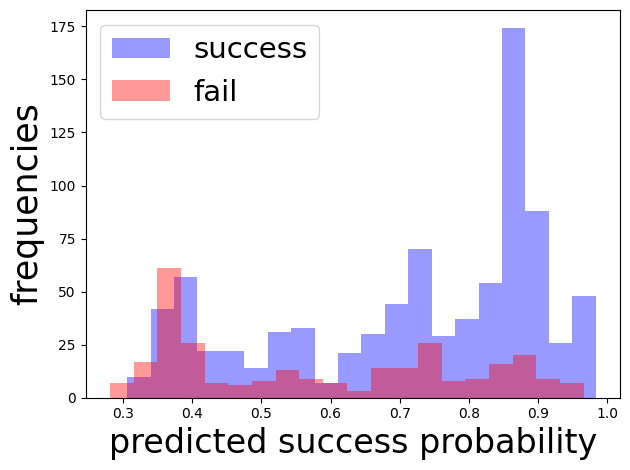

In [7]:
hint_model_path = "save_model/" + base_name + ".ckpt"
model = torch.load(hint_model_path)
model.bootstrap_test(test_loader)